# Explaining SHAP through Code

In this assignment, I will be demonstrating the use of SHAP (SHapley Additive exPlanations) to interpret a machine learning model

SHAP is a powerful tool that helps explain the output of any machine learning model by computing the contribution of each feature to the prediction.

### The Dataset

- For this demonstration, I’ll be using the Adult Income Dataset (often referred to as the Census Income or “loan approval-like” dataset).

- It contains demographic and financial information about individuals, such as age, education, occupation, marital status, and working hours per week; and predicts whether a person’s annual income exceeds $50K.

- Although the dataset is about income classification, its structure closely resembles real-world loan approval models, where the goal is to predict whether an applicant qualifies for approval based on similar socioeconomic features.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [3]:
# Load Data
from sklearn.datasets import fetch_openml
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame

### Exploratory Data Analysis

In [4]:
# basic info about the dataset
print(df.info())

# first few rows
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  int64   
 3   education       48842 non-null  category
 4   education-num   48842 non-null  int64   
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  int64   
 11  capital-loss    48842 non-null  int64   
 12  hours-per-week  48842 non-null  int64   
 13  native-country  47985 non-null  category
 14  class           48842 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.7 MB
None
   age  workclass  fnlwgt     education  education-nu

In [5]:
# Missing values and summary statistics
print(df.isnull().sum())

# Statistics for numerical features
print(df.describe())

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
class                0
dtype: int64
                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
ma

Here are some observations from the EDA:
- The dataset contains 48,842 entries and 15 columns — a mix of numerical and categorical features.
- Key numeric features include age, education-num, capital-gain, capital-loss, and hours-per-week
- Categorical features like workclass, education, marital-status, occupation, and relationship describe demographic and employment characteristics.

There are a few missing or null values:
- workclass (~2,799 missing)
- occupation (~2,809 missing)
- native-country (~857 missing)

Numerical distributions reveal:
- The average age of individuals is around 38 years.
- Most people work approximately 40 hours per week.
- Features like capital-gain and capital-loss are highly skewed, with most values being 0 and a few extreme outliers.

These insights suggest that minimal cleaning is required, and careful encoding of categorical features will be essential before training our model.

In [6]:
# checking the target variable distribution
df['class'].value_counts(normalize=True)

class
<=50K    0.760718
>50K     0.239282
Name: proportion, dtype: float64

### Cleaning and Preprocessing the Data

The target variable class is slightly imbalanced. A majority of individuals earn ≤ $50K.
This mirrors real-world data, where higher income levels are relatively rarer.

In [7]:
df = df.dropna()
df = df.copy()
encoders = {}
label_cols = df.select_dtypes(include='category').columns.tolist()

for col in label_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

X = df.drop(["class", "fnlwgt"], axis=1)
y = df["class"].apply(lambda x: 1 if x == '>50K' else 0)

- I removed any rows containing missing entries in columns like workclass, occupation, and native-country to avoid bias or inconsistency during training
- Since machine learning models require numerical input, all categorical columns were label encoded using LabelEncoder().
- The feature matrix X includes demographic and employment-related columns.
- The target variable y represents income:
    - 1 - Income greater than $50K
    - 0 - Income less than or equal to $50K
- The fnlwgt column (final weight) was dropped, as it doesn’t contribute directly to prediction.

In [8]:
from sklearn.utils import resample

# removing class imbalance by upsampling the minority class
# separate majority and minority classes
df_majority = df[df["class"] == 0]
df_minority = df[df["class"] == 1]

print("Majority samples:", len(df_majority))
print("Minority samples:", len(df_minority))

# upsampling the minority class
df_minority_upsampled = resample(
    df_minority,
    replace=True,                     
    n_samples=len(df_majority),        
    random_state=42
)

# combining majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])
print("Balanced dataset size:", df_balanced.shape)

# shuffling the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

Majority samples: 34014
Minority samples: 11208
Balanced dataset size: (68028, 15)


In [9]:
X = df_balanced.drop(["class", "fnlwgt"], axis=1)
y = df_balanced["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

To ensure the model learns fairly from both classes, I used random upsampling to duplicate samples from the minority class until both classes had equal representation.  
This helps the model avoid bias toward the majority class and improves interpretability when using SHAP 

### Training the Model

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest Classifier
model_adult = RandomForestClassifier(random_state=42)
model_adult.fit(X_train, y_train)
print(classification_report(y_test, model_adult.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      6767
           1       0.88      0.96      0.92      6839

    accuracy                           0.91     13606
   macro avg       0.92      0.91      0.91     13606
weighted avg       0.92      0.91      0.91     13606



I trained a Random Forest Classifier on the preprocessed data, using an 80-20 train-test split.
Random Forest is an ensemble method that builds multiple decision trees and averages their predictions for better accuracy and generalization.

The model achieved strong performance on the test set, with precision, recall, and F1-scores around 0.9. This shows that the model has learned meaningful patterns from the data, but to understand why it makes those predictions, I’ll use SHAP next.

### SHAP (Local + Global)

SHAP combines ideas from cooperative game theory and local explanations to show how each feature contributes to a model’s output.
- Global Interpretations: help us understand which features have the most overall influence across all predictions.
- Local Interpretations: explain why a specific individual prediction was made, showing feature contributions for a single instance.

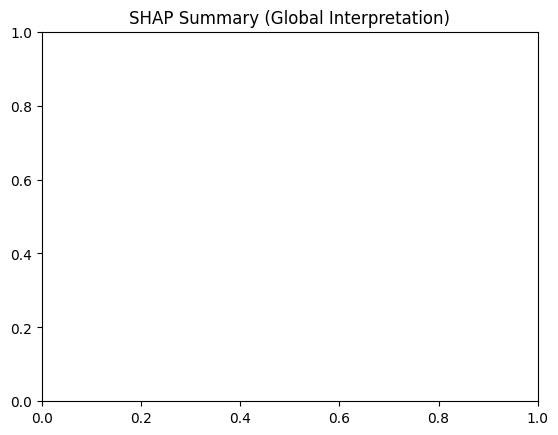

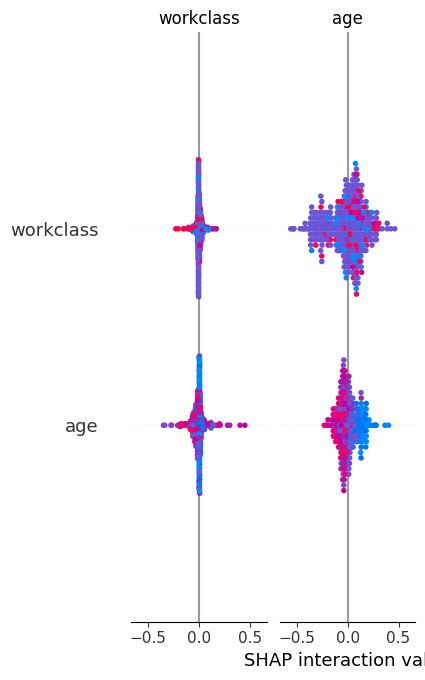

SHAP Local Explanation for Predicted Class: 0


ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (13, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import shap

# Initializing SHAP explainer
explainer = shap.TreeExplainer(model_adult) # becuase normally, shap uses the KernelExplainer for Random Forests which is much slower

sample_X = X_test.sample(500, random_state=42)
shap_values = explainer.shap_values(sample_X) # using a sample for speed

# global explanation
plt.title("SHAP Summary (Global Interpretation)")
shap.summary_plot(shap_values[1], sample_X)

# local explanation 
# Choosing a random example from test set
idx = 0
predicted_class = model_adult.predict(sample_X.iloc[[idx]])[0]
print(f"SHAP Local Explanation for Predicted Class: {predicted_class}")

# getting the explanation for the first instance
exp = shap.Explanation(
    values=shap_values[1][idx],                
    base_values=explainer.expected_value[1],  
    data=sample_X.iloc[idx],
    feature_names=list(sample_X.columns)
)

shap.plots.waterfall(exp)